In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import time
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, wait
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
import project_path
from src.util.generate_connected_graph import generate_connected_graph
from src.util.generate_lr_data import generate_low_rank_data
from src.util.generate_anomaly import generate_spatio_temporal_anomaly
# from src.algos.lr_stss import lr_stss
from src.algos.lr_stss_modified import lr_stss_modified
from src.algos.lr_sts import lr_sts_hard
from src.algos.lr_sss import lr_sss_hard
from src.algos.horpca_singleton import horpca_singleton
from dask.distributed import as_completed
from tqdm import tqdm

In [2]:
client = Client(n_workers=125)
client

<Client: 'tcp://127.0.0.1:40926' processes=125 threads=250, memory=100.00 GiB>

In [17]:
## Control Variables
gt = 'grid'
graph_param = (8,8)
amp =1
window = 'boxcar'
distribution = 'bernoulli'
local_distribution = 'constant'
dims = (64,24,7,50)
ranks = (8,8,5,4)
NoG = 1
NoT = 5
NoA = 450
time_m = 2
local_m = 1
lda_2 = 1000
psi = 23
maxit = 200
maxit_horpca = 200
### LRSTSS Hyperparameters
lda_1 = 0.00012104 #0.0003542734521053448 # np.logspace(1,-3,5)
lda_l = 0.00016974 #0.002062120382 # np.logspace(1,-3,5)
lda_t = 0.00010008 #0.00013502437304801454 # np.logspace(1,-3,5)
### LR_SSS lda_t=0 Submissions
# input_['lda_t'] = 0
# input_['lda_l'] = 0.1166 # 0.2921
# input_['lda_1'] = 1.14795# 8.375634044352
### LR_STS lda_l=0 Submissions
# input_['lda_t'] = 0.2
# input_['lda_l'] = 0
# input_['lda_1'] = 1.2

## Independent variables
duration = np.array([1,2,3,4,5,6,7,8,10,12,14,16,18,20,22,24])
rad = 1
metadata = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': duration,
            'anomaly_radius': rad,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'time_mode': time_m,
            'local_mode': local_m,
            'lda_2':lda_2,
            'lda_1':lda_1,
            'lda_l':lda_l,
            'lda_t':lda_t,
            'psi': psi,
            'maxit':maxit
            }

metadata_horpca = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': duration,
            'anomaly_radius': rad,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'maxit':maxit_horpca,
            }

In [10]:
# Define experiment function
def run_exp(X, Y, an_m, inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    psi = inputs['psi']
    res = lr_stss_modified(Y, An, time_m,local_m, verbose=0, max_it=maxit,
        lda2=inputs['lda_2'], lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': inputs['duration'],
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

def run_lrsts_exp(X,Y,an_m,inputs):
    psi = inputs['psi']
    res = lr_sts_hard(Y, time_m, verbose=0, max_it=maxit,
        lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': inputs['duration'],
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

def run_lrsss_exp(X,Y,an_m,inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    L = np.eye(Y.shape[local_m-1]) - An
    psi = inputs['psi']
    res = lr_sss_hard(Y, L, local_m, verbose=0, max_it=maxit,
        lda1=inputs['lda_1'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': inputs['duration'],
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result
    
def run_horpca_exp(X,Y, an_m, inputs):
    res = horpca_singleton(Y, lda1=1/np.sqrt(np.max(Y.shape)), rho=1, step_size_growth=-1, maxit=maxit_horpca, verbose=0)
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['E']).ravel()),
              'rec_err': np.linalg.norm(res['Y']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': inputs['duration'],
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': 1/np.sqrt(np.max(Y.shape)),
              'psi':1,
              'maxit': maxit_horpca,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

In [18]:
cwd = os.getcwd()
fname_lrssts = os.path.join(cwd, 'results','lrstss_exp2_rad1_buyuk3.hdf5')
fname_horpca = os.path.join(cwd, 'results','horpca_exp2_rad1_buyuk3.hdf5')
fname_lrsts = os.path.join(cwd, 'results','lrsts_exp2_rad1_buyuk3.hdf5')
fname_lrsss = os.path.join(cwd, 'results','lrsss_exp2_rad1_buyuk3.hdf5')
# fname = 'lr_stss_exp1_hpcc.hdf5'
key = 'grid'

if True:
    try:
        del futures_lrssts
    except:
        pass
    try:
        del futures_horpca
    except:
        pass
    try:
        del futures_lrsts
    except:
        pass
    try:
        del futures_lrsss
    except:
        pass

seed = 12345678+4000 + 21231
input_ = {}
for i in range(NoG):
    G,sd = generate_connected_graph(graph_param, gt, radius=graph_param, seed=seed)
    input_['G'] = G
    input_['graph_type'] = gt
    input_['graph_seed'] = sd
    seed = sd
    futures_lrssts = []
    futures_horpca = []
    futures_lrsts = []
    futures_lrsss = []
    results=[[],[],[],[]]
    for j in tqdm(range(NoT)):
        
        # Generate low rank normal data
        X = generate_low_rank_data(dims, ranks, seed)
        X = 1*X/np.std(X)
        input_['X'] = X
        input_['trial'] = j
        # Generate anomaly
        for k in range(len(duration)):
            input_['NoA'] = NoA
            input_['duration'] = duration[k]
            an, an_m = generate_spatio_temporal_anomaly(dims, G, NoA, duration=duration[k],
                                                        radius=rad, seed=seed,
                time_m=time_m, local_m=local_m, window_type='boxcar', amplitude=amp,
                distribution=distribution, local_dist='constant')
            input_['anomaly_seed'] = seed
            Y = X+an
            seed +=1
            
            # LR_SSTS Submissions
            input_['lda_1'] = lda_1
            input_['lda_l'] = lda_l
            input_['lda_t'] = lda_t
            input_['lda_2'] = lda_2
            input_['psi'] = psi
            futures_lrssts.append(client.submit(run_exp, X, Y, an_m, input_))
            
            # LR_SSS lda_t=0 Submissions
            input_['lda_t'] = 0
            input_['lda_l'] = 0.1166 # 0.2921
            input_['lda_1'] = 1.14795# 8.375634044352
            futures_lrsss.append(client.submit(run_lrsss_exp, X,Y,an_m, input_))
            
            # LR_STS lda_l=0 Submissions
            input_['lda_t'] = 0.2
            input_['lda_l'] = 0
            input_['lda_1'] = 1.2
            futures_lrsts.append(client.submit(run_lrsts_exp, X, Y, an_m, input_))
            
            # HoRPCA Submissions
            futures_horpca.append(client.submit(run_horpca_exp, X,Y, an_m, input_))

for future in as_completed(futures_lrssts):
    results[0].append(future.result())
    del future

for future in as_completed(futures_lrsts):
    results[1].append(future.result())
    del future

for future in as_completed(futures_lrsss):
    results[2].append(future.result())
    del future

for future in as_completed(futures_horpca):
    results[3].append(future.result())
    del future


idx = np.arange(len(results[0]))
df = pd.DataFrame(results[0], index=idx)
with pd.HDFStore(fname_lrssts) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[1]))
df = pd.DataFrame(results[1], index=idx)
with pd.HDFStore(fname_lrsts) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[2]))
df = pd.DataFrame(results[2], index=idx)
with pd.HDFStore(fname_lrsss) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[3]))
df = pd.DataFrame(results[3], index=idx)
with pd.HDFStore(fname_horpca) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata_horpca
for i in range(len(results)):
    del results[-1]

Graph is connected.


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.65s/it]
2023-08-29 14:09:14,782 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 563.26 MiB -- Worker memory limit: 819.20 MiB


In [6]:
progress(futures)

2023-06-26 10:03:30,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:30,096 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:30,122 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

VBox()

2023-06-26 10:03:30,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:30,405 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:30,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:32,929 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:32,945 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:33,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:34,503 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:34,583 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:34,615 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:36,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:36,225 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:36,334 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:38,516 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:38,551 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:38,657 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:41,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:41,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:41,097 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:42,756 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:42,773 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:42,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:44,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:44,259 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:44,307 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:45,723 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:45,774 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:45,778 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:47,931 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:48,364 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:48,389 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:50,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:50,327 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:50,606 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:52,696 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:52,730 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:52,751 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:54,168 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:54,308 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:54,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:55,597 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:55,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:55,823 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:03:58,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:58,389 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:03:58,463 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:00,395 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:00,427 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:00,708 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:02,632 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:02,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:02,667 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:04,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:04,128 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:04,130 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:05,316 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:05,423 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:05,598 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:07,779 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:07,789 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:07,880 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:10,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:10,152 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:10,178 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:12,437 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:12,496 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:12,541 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:13,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:13,980 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:14,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:15,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:15,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:15,316 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:17,218 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:17,325 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:17,472 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:19,812 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:19,928 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:19,959 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:22,336 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:22,437 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:22,496 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:24,200 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:24,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:24,231 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:25,521 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:25,798 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:25,937 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:27,879 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:27,890 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:27,980 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:04:30,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:30,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:04:30,380 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

In [8]:
from dask.distributed import as_completed
fname = 'lr_stss_exp2_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)

for future in as_completed(futures):
    df = pd.DataFrame(future.result(), index=[i])
    with pd.HDFStore(fname) as storedata:
        storedata.append(key, df)
    del future
with pd.HDFStore(fname) as storedata:
    storedata.get_storer(key).attrs.metadata=metadata

2023-06-26 10:05:01,106 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:01,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:01,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:02,948 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:02,997 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:03,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:04,498 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:04,524 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:04,530 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:06,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:06,239 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:06,336 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:08,282 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:08,432 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:08,591 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:10,925 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:11,207 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:11,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:13,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:13,037 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:13,095 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:15,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:15,382 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:15,415 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:17,075 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:17,090 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:17,117 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:19,374 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:19,624 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:19,687 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:22,073 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:22,074 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:22,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:24,446 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:24,569 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:24,601 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:25,717 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:25,763 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:25,822 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:28,276 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:28,279 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:28,284 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:30,428 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:30,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:30,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:32,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:32,977 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:33,137 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:34,380 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:34,472 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:34,548 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:35,628 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:35,672 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:35,723 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:37,620 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:37,923 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:38,173 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:40,021 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:40,310 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:40,428 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:42,499 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:42,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:42,736 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:44,120 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:44,145 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:44,146 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:45,581 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:45,607 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:45,729 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:47,480 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:47,719 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:48,022 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:50,007 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:50,022 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:50,310 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:52,569 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:52,598 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:52,736 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:54,216 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:54,244 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:54,244 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:55,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:55,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:55,860 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:05:57,481 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:57,818 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:05:58,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:00,125 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:00,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:00,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:02,504 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:02,600 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:02,670 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:04,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:04,097 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:04,244 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:05,511 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:05,514 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:05,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:07,347 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:07,373 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:07,481 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:09,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:09,738 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:09,887 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:12,045 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:12,261 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:12,274 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:13,829 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:13,846 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:14,031 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:15,311 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:15,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:15,389 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:16,802 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:16,974 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:17,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:19,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:19,566 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:19,652 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:22,111 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:22,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:22,261 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:23,929 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:24,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:24,178 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:25,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:25,389 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:25,401 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:26,975 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:27,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:27,324 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:29,463 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:29,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:29,567 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:31,914 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:31,964 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:31,998 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:33,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:33,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:33,596 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:35,098 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:35,158 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:35,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:36,496 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:36,722 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:36,736 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:38,781 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:39,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:39,189 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:41,295 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:41,426 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:41,606 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:43,537 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:43,537 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:43,548 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:44,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:44,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:45,024 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:46,217 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:46,225 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:46,257 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:48,572 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:48,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:48,690 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:50,811 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:50,848 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:50,928 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:53,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:53,341 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:53,379 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:54,816 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:54,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 238.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:54,908 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:56,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:56,127 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:56,172 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:06:58,120 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:58,422 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:06:58,670 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:00,522 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:00,848 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:00,911 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:02,800 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:02,967 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:03,037 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:04,498 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:04,543 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:04,618 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:05,812 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:05,879 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:05,913 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:07,621 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:07,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:07,734 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:10,321 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:10,385 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:10,409 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:12,660 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:12,669 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:12,673 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:14,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:14,329 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:14,433 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:15,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:15,815 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:15,880 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:17,720 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:17,735 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:17,772 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:20,321 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:20,386 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:20,426 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:23,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:23,136 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:23,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:24,844 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:24,916 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:24,979 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:26,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:26,181 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:26,230 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:28,320 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:28,523 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:28,772 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:30,607 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:30,722 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:31,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:32,901 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:33,137 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:33,168 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:34,743 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:34,798 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:34,817 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:36,119 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:36,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:36,181 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:38,419 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:38,622 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:38,772 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:40,822 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:41,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:41,178 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:43,169 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:43,236 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:43,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:44,744 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:44,843 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:44,897 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:46,111 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:46,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:46,121 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:48,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:48,518 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:48,722 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:50,922 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:51,150 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:51,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:53,267 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:53,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:53,336 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:54,842 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:54,844 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:54,898 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:56,376 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:56,472 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:56,506 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:07:58,518 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:58,773 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:07:58,822 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:00,725 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:01,021 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:01,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:03,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:03,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:03,398 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:04,997 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:05,015 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:05,114 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:06,475 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:06,508 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:06,528 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:08,189 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:08,220 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:08,519 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:10,686 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:10,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:10,727 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:13,072 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:13,101 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:13,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:14,731 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:14,879 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:14,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:16,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:16,181 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:16,212 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:18,074 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:18,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:18,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:20,451 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:20,623 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:20,686 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:22,970 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:23,031 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:23,074 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:24,944 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:24,945 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:24,979 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:26,214 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:26,251 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:26,280 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:28,181 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:28,191 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:28,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:30,686 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:30,721 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:30,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:33,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:33,173 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:33,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:34,944 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:35,044 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:35,077 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:36,347 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:36,381 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:36,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:38,282 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:38,289 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:38,335 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:40,785 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:40,827 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:40,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:43,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:43,274 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:43,301 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:45,044 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:45,045 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:45,079 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:46,313 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:46,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:46,413 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:48,248 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:48,272 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:48,291 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:50,652 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:50,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:50,820 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:53,044 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:53,056 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:53,070 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:54,772 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:54,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:54,846 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:56,414 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:56,415 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:56,447 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:08:58,347 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:58,391 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:08:58,420 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:00,751 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:00,920 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:00,986 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:03,131 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:03,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:03,171 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:05,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:05,242 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:05,279 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:06,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:06,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:06,620 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:08,421 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:08,446 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:08,489 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:11,007 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:11,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:11,126 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:13,373 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:13,374 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:13,504 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:15,244 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:15,280 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:15,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:16,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:16,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:16,622 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:18,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:18,492 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:18,521 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:20,951 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:21,019 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:21,086 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:23,473 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:23,600 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:23,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:25,233 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:25,242 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:25,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:26,514 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:26,529 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:26,548 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:28,318 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:28,326 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:28,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:30,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:30,825 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:30,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:33,262 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:33,332 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:33,343 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:35,070 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:35,131 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:35,152 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:36,514 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:36,529 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:36,555 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:38,419 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:38,424 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:38,474 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:40,773 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:40,825 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:40,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:43,097 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:43,111 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:43,344 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:44,865 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:44,930 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:44,955 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:46,390 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:46,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:46,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:48,204 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:48,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:48,425 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:50,656 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:50,774 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:50,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:53,098 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:53,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:53,345 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:54,963 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:55,034 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:55,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:56,489 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:56,513 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:56,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:09:58,214 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:58,301 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:09:58,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:00,550 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:00,567 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:00,715 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:03,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:03,212 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:03,346 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:05,228 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:05,251 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:05,327 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:06,514 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:06,516 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:06,589 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:08,302 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:08,313 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:08,574 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:10,814 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:10,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:10,874 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:13,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:13,443 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:13,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:15,327 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:15,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:15,370 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:16,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:16,613 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:16,688 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:18,318 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:18,400 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:18,574 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:20,668 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:20,817 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:20,856 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:23,249 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:23,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:23,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:25,076 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:25,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:25,246 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:26,689 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:26,712 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:26,713 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:28,402 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:28,414 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:28,626 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:30,856 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:30,914 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:30,975 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:33,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:33,249 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:33,397 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:34,939 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:35,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:35,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:36,427 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:36,459 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:36,498 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:37,697 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:37,723 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:37,758 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:40,088 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:40,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:40,379 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:42,427 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:42,452 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:42,622 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:44,577 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:44,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:44,733 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:46,016 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:46,080 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:46,110 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:47,675 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:47,699 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:47,821 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:50,328 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:50,479 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:50,489 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:52,721 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:52,796 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:53,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:54,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:55,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:55,096 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:56,246 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:56,472 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:56,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:10:57,775 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:57,822 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:10:57,857 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:00,427 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:00,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:00,588 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:02,721 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:02,797 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:03,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:05,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:05,097 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:05,236 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:06,472 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:06,527 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:06,627 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:07,857 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:07,876 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:07,921 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:10,081 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:10,188 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:10,528 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:12,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:13,063 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:13,326 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:15,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:15,196 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:15,336 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:16,571 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:16,627 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:16,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:17,861 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:17,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:17,922 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:20,071 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:20,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:20,289 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:22,521 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:22,528 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:22,579 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:24,735 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:24,876 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:24,933 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:26,215 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:26,233 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:26,308 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:27,611 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:27,720 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:27,780 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:29,481 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:29,519 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:29,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:32,347 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:32,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:32,559 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:34,877 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:35,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:35,038 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:36,309 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:36,328 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:36,447 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:37,816 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:37,881 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:37,898 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:39,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:40,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:40,171 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:42,347 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:42,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:42,627 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:45,097 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:45,137 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:45,140 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:46,617 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:46,771 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:46,808 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:48,065 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:48,071 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:48,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:50,379 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:50,488 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:50,779 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:53,095 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:53,163 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:53,505 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:55,347 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:55,438 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:55,564 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:56,929 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:56,930 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:56,959 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:11:58,221 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:58,258 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:11:58,622 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:00,587 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:00,879 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:00,927 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:03,163 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:03,196 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:03,604 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:05,537 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:05,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:05,646 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:07,026 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:07,059 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:07,068 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:08,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:08,722 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:08,890 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:11,150 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:11,264 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:11,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:13,704 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:13,713 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:13,725 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:15,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:15,663 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:15,745 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:17,158 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:17,320 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:17,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:19,225 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:19,293 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:19,301 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:21,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:21,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:21,820 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:24,049 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:24,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:24,173 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:25,832 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:25,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:26,028 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:27,321 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:27,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:27,415 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:29,225 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:29,273 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:29,301 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:31,516 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:31,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:31,658 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:33,998 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:34,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:34,149 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:35,765 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:35,846 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:35,875 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:12:37,313 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:37,321 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:37,335 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:37,358 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:12:38,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:39,061 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:39,090 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:39,114 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:12:40,763 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:40,789 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:40,861 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:41,063 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:41,161 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:12:41,961 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:41,976 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:42,036 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:42,064 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:42,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:12:43,363 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:43,375 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:43,476 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:43,561 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:43,635 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:12:44,936 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:44,967 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:44,999 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:45,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:12:46,335 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:46,351 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:46,355 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:46,369 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:12:47,244 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:47,251 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:47,261 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:47,267 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:47,276 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:12:48,421 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:48,423 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:48,450 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:48,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:12:49,624 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:49,651 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:49,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:49,711 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:49,723 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:12:51,452 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:51,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:51,550 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:51,567 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:12:52,729 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:52,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:52,811 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:52,823 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:12:53,924 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:53,926 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:53,929 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:54,011 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:54,023 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:54,025 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:12:55,162 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:55,225 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:55,262 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:55,276 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:55,276 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:12:56,312 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:56,325 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:56,331 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:56,355 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:56,361 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:12:57,421 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:57,425 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:57,429 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:57,512 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:57,529 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:12:58,512 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:58,526 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:58,530 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:58,557 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:58,571 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:12:59,736 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:59,750 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:59,773 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:59,810 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:12:59,836 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:01,328 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:01,329 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:01,329 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:01,364 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:13:02,375 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:02,425 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:02,461 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:02,462 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:02,476 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:03,562 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:03,563 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:03,635 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:03,736 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:03,763 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:04,801 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:04,835 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:04,862 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:04,962 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:04,968 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:06,226 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:06,228 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:06,326 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:06,331 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:06,398 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:07,298 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:07,314 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:07,327 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:07,330 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:13:08,219 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:08,226 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:08,234 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:08,273 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:08,327 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:09,291 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:09,334 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:09,350 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:09,362 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:09,449 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:10,174 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:10,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:10,221 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:10,226 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:10,227 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:11,488 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:11,521 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:11,527 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:11,528 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:11,529 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:12,373 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:12,406 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:12,422 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:12,426 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:13:13,251 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:13,251 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:13,288 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:13,312 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:13,321 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:13,323 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:13:14,225 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:14,227 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:14,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:14,272 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:14,288 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:15,102 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:15,137 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:15,173 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:15,335 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:13:16,373 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:16,387 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:16,427 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:16,428 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:16,455 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:13:17,288 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:17,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:17,308 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:17,316 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:13:18,435 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:18,497 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:18,521 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:18,566 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:13:19,620 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:19,624 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:19,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:19,689 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:13:20,748 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:20,762 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 258.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:20,772 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:20,869 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:20,979 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:21,647 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:21,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:21,663 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:21,707 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:13:22,489 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:22,505 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:22,507 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:22,521 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:22,552 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:23,320 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:23,326 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:23,370 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:23,406 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 10:13:24,421 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:24,444 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:24,448 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:24,461 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:13:25,621 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:25,632 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:25,655 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:25,676 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:25,706 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:26,469 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:26,489 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:26,497 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:26,507 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 10:13:27,108 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:27,123 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:27,146 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:13:27,727 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:27,744 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:27,747 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:27,755 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:27,789 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:27,799 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:28,375 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:28,388 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:28,417 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:28,427 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:28,442 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:29,000 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:29,016 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:29,022 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:29,025 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:29,035 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:13:29,943 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:29,983 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:30,015 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:30,035 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:13:30,797 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:30,814 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:30,824 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:30,829 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:30,855 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:30,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:13:31,643 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:31,651 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:31,652 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:31,690 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:31,706 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:32,485 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:32,498 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:32,515 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:32,523 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:32,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:33,315 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:33,321 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:33,325 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:33,327 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:33,327 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:34,130 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,151 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,200 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,205 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,221 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,231 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:13:34,798 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,814 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,831 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:34,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:13:36,281 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,301 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,301 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,307 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,321 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,328 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:13:36,907 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,922 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,929 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,931 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:36,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:37,572 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:37,580 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:37,581 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:37,582 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:37,595 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:38,001 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,020 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,022 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,029 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,045 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,056 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:13:38,622 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,663 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:38,680 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:13:39,301 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,302 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,322 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,327 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,329 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,355 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:39,921 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,950 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,980 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:39,990 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:40,001 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:40,021 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:40,876 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:40,879 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:40,881 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:40,882 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:40,899 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:40,943 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:41,751 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:41,764 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:41,780 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:41,838 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:13:42,380 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:42,382 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:42,419 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:42,429 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:42,433 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:43,237 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:43,245 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:43,253 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:43,256 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:43,304 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:43,306 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:44,136 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:44,143 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:44,173 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:44,200 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:44,219 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:13:44,970 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:44,974 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:44,979 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:45,000 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:13:45,936 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:45,988 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:45,996 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:46,006 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:46,042 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:46,596 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:46,597 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:46,636 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:46,645 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:46,658 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:13:47,223 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:47,235 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:47,246 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:47,247 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:13:47,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:47,917 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:47,926 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:47,928 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:13:48,605 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:48,605 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:48,622 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:48,636 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:48,651 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:49,546 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:49,548 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:49,573 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:49,580 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:49,590 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:13:50,179 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:50,181 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:50,182 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:50,214 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:50,219 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:51,111 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,126 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,156 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,175 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,179 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:13:51,759 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,775 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,780 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,790 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,805 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:51,811 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:52,374 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:52,375 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:52,406 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:52,411 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:52,419 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:13:53,274 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,282 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,304 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,329 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,358 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,364 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:53,918 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,928 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,946 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,950 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,955 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:53,959 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:13:54,548 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:54,565 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:54,568 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:54,572 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:54,611 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:54,627 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:13:55,174 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,177 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,191 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,210 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,226 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,227 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:55,811 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,829 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,832 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,848 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:55,850 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:13:56,843 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:56,859 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:56,869 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:56,871 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:56,873 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:57,513 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:57,516 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:57,526 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:57,527 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:13:57,928 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:57,948 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:57,960 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:57,971 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:57,974 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:58,002 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:13:58,556 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:58,569 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:58,571 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:58,581 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:58,596 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:58,616 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:13:59,196 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,222 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,229 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,236 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,251 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:13:59,855 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,856 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,874 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:13:59,898 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:00,491 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:00,528 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:00,572 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:00,573 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:00,581 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:00,613 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:14:01,396 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:01,448 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:01,473 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:01,475 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:01,496 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:01,506 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:14:02,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:02,043 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:02,054 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:02,071 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:14:02,699 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:02,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:02,731 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:02,742 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:02,768 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:03,568 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:03,590 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:03,621 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:03,627 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:03,631 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:03,652 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:14:04,517 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:04,526 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:04,564 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:04,571 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:04,590 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:04,601 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:14:05,467 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:05,518 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:05,568 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:05,618 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:05,620 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:05,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:14:06,314 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:06,319 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:06,320 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:06,346 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:06,365 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 10:14:07,014 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,019 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,022 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,025 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,027 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,043 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:14:07,858 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,868 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,877 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:07,922 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:14:08,796 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:08,814 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:08,819 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:08,820 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:14:09,656 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:09,690 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:09,700 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:09,713 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:14:10,522 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:10,575 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:10,580 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:10,587 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:10,589 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:14:11,488 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:11,620 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:11,650 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:11,679 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:11,721 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:12,571 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:12,602 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:12,613 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:12,614 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:12,627 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:12,627 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:14:13,216 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:13,232 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:13,249 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:13,251 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:13,260 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:14:13,921 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:13,928 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:13,936 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:13,968 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:14,015 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:14,027 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:14:14,572 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:14,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:14,579 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:14,613 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:14,614 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:14:15,428 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:15,437 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:15,497 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:15,505 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:15,516 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:16,267 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,291 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,297 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,314 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,314 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,346 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:14:16,914 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,927 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,931 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,932 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:16,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:14:17,514 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:17,516 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:17,522 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 266.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:17,532 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:17,538 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:14:18,133 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:18,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:18,181 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:18,201 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 10:14:18,770 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:18,785 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:18,798 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:18,813 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:18,816 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:19,416 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:19,420 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:19,431 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:19,436 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 10:14:20,113 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:20,117 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:20,121 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:20,128 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:20,133 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:20,962 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:20,972 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:20,985 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:21,027 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:21,037 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:21,043 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:14:21,826 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:21,830 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:21,885 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:21,931 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:21,962 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:14:22,686 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:22,686 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:22,731 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:22,737 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:22,743 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:14:23,332 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:23,345 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:23,347 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:23,362 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:23,364 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:24,018 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,026 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,062 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,070 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:14:24,871 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,874 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,884 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,917 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,943 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:24,954 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:14:25,571 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:25,574 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:25,615 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:25,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:25,670 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:26,195 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:26,212 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:26,214 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:26,226 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:26,243 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 10:14:26,850 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:26,854 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:26,869 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 10:14:27,727 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:27,727 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:27,728 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:27,730 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 10:14:28,389 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:28,414 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:28,425 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:28,449 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:28,507 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 10:14:29,271 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:29,276 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:29,294 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:29,316 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:29,332 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:29,361 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:14:30,295 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:30,321 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:30,327 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:30,371 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:30,376 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:30,389 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 10:14:31,161 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:31,172 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:31,176 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:31,177 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:31,190 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 10:14:31,995 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,014 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,025 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,028 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,032 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,050 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 10:14:32,670 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,673 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,679 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,694 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,726 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:32,731 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 10:14:33,331 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:33,372 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:33,378 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:33,393 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 10:14:33,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

In [34]:
fname = 'lr_stss_exp2_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)
with pd.HDFStore(fname) as storedata:
    df = storedata[key]

In [12]:
cwd = os.getcwd()
fname_lrstss = os.path.join(cwd, 'results','lrstss_exp2_rad1_buyuk2.hdf5')
fname_horpca = os.path.join(cwd, 'results','horpca_exp2_rad1_buyuk2.hdf5')
fname_lrsts = os.path.join(cwd, 'results','lrsts_exp2_rad1_buyuk2.hdf5')
fname_lrsss = os.path.join(cwd, 'results','lrsss_exp2_rad1_buyuk2.hdf5')
key = 'grid'

with pd.HDFStore(fname_lrstss) as storedata:
    df_lrssts = storedata[key]
with pd.HDFStore(fname_lrsts) as storedata:
    df_lrsts = storedata[key]
with pd.HDFStore(fname_lrsss) as storedata:
    df_lrsss = storedata[key]
with pd.HDFStore(fname_horpca) as storedata:
    df_horpca = storedata[key]

In [13]:
dfm_lrstss = df_lrssts.groupby(['anomaly_duration','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrstss_2 = df_lrssts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrstss = dfm_lrstss.groupby(['anomaly_duration'])['auc'].max().reset_index()
dfm2_lrstss_2 = dfm_lrstss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(df_lrssts.to_html()))

dfm_lrsts = df_lrsts.groupby(['anomaly_duration','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrsts_2 = df_lrsts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrsts = dfm_lrsts.groupby(['anomaly_duration'])['auc'].max().reset_index()
dfm2_lrsts_2 = dfm_lrsts_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(dfm2_lrsts_2.to_html()))

dfm_lrsss = df_lrsss.groupby(['anomaly_duration','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrsss_2 = df_lrsss.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrsss = dfm_lrsss.groupby(['anomaly_duration'])['auc'].max().reset_index()
dfm2_lrsss_2 = dfm_lrsss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(dfm2_lrsss_2.to_html()))

dfm_horpca_2 = df_horpca.groupby(['anomaly_cardinality'])[['auc','rec_err']].mean().reset_index()
dfm_horpca = df_horpca.groupby(['anomaly_duration'])[['auc', 'rec_err']].mean().reset_index()
dfm_horpca_std = df_horpca.groupby(['anomaly_duration'])[['auc', 'rec_err']].std()
# display(HTML(dfm_horpca_2.to_html()))

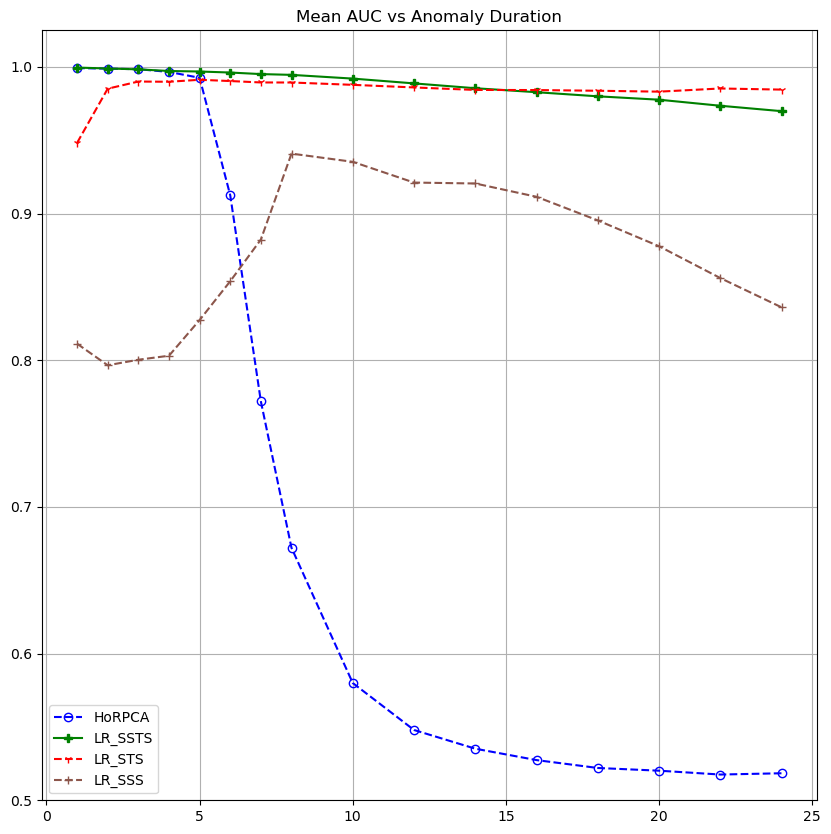

In [16]:
# display(dfm2)
fig, ax = plt.subplots(1,1, figsize=(10,10))
# dfm2.plot() /(7*24*20*40)
ax.plot(dfm_horpca['anomaly_duration'],dfm_horpca['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
ax.plot(dfm2_lrstss['anomaly_duration'],dfm2_lrstss['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
ax.plot(dfm2_lrsts['anomaly_duration'],dfm2_lrsts['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
ax.plot(dfm2_lrsss['anomaly_duration'],dfm2_lrsss['auc'], label='LR_SSS', linestyle='--',marker='+', fillstyle='none', c='C5')
# ax.plot(dfm_horpca_2['anomaly_cardinality']/(7*24*20*40),dfm_horpca_2['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
# ax.plot(dfm2_lrstss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrstss_2['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
# ax.plot(dfm2_lrsts_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsts_2['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
# ax.plot(dfm2_lrsss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsss_2['auc'], label='LR_SSS', linestyle=':',marker='+', fillstyle='none', c='y')
ax.grid()
ax.set_title("Mean AUC vs Anomaly Duration");
ax.set_ylim([0.5,1.025]);
ax.legend()

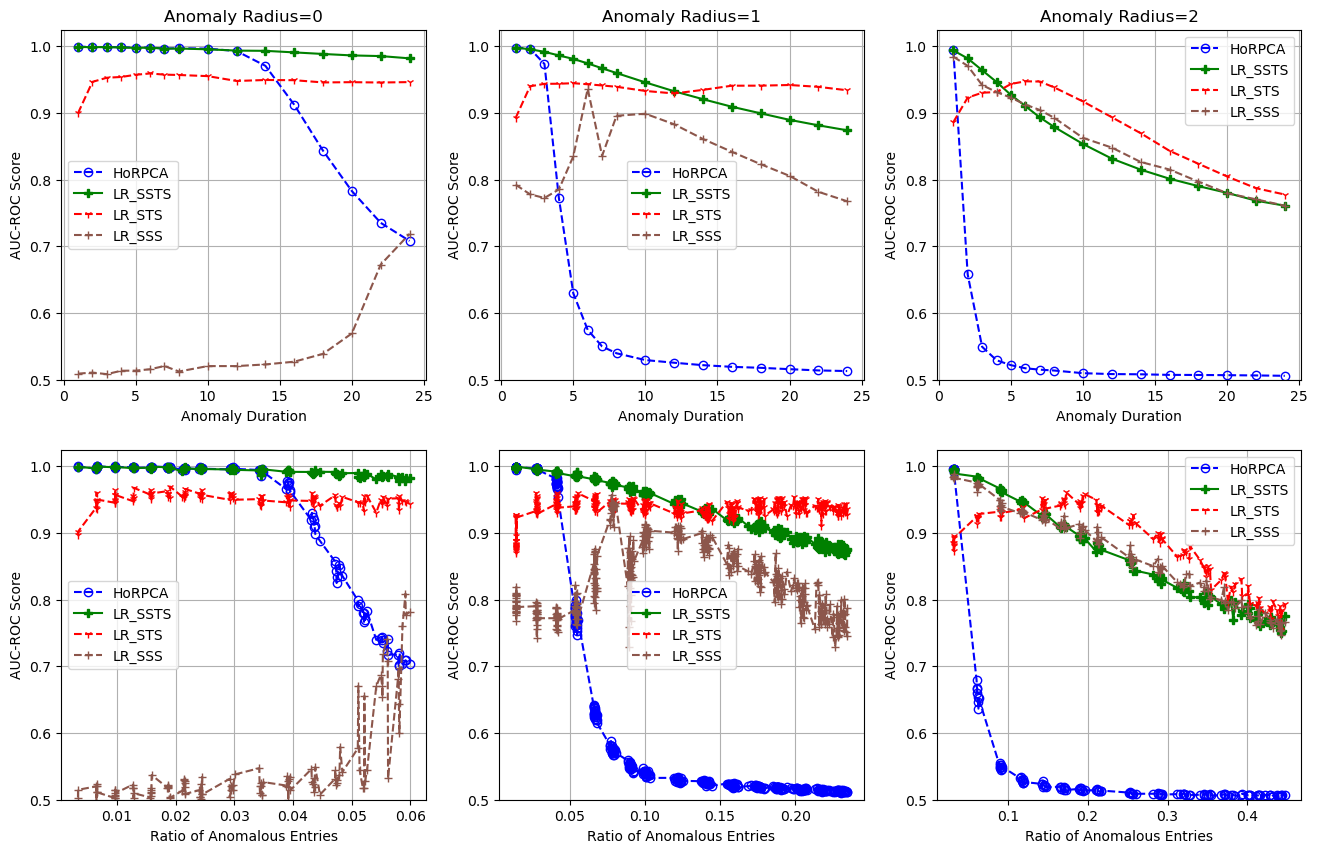

In [34]:
cwd = os.getcwd()
fig, axs = plt.subplots(2,3, figsize=(16,10))
data_names = ['exp2_2','exp2_rad1_2','exp2_4']
radiuses = ['Anomaly Radius=0', 'Anomaly Radius=1', 'Anomaly Radius=2']
for i,dn in enumerate(data_names):
    fname_lrstss = os.path.join(cwd, 'results','lrstss_'+dn+'.hdf5')
    fname_horpca = os.path.join(cwd, 'results','horpca_'+dn+'.hdf5')
    fname_lrsts = os.path.join(cwd, 'results','lrsts_'+dn+'.hdf5')
    fname_lrsss = os.path.join(cwd, 'results','lrsss_'+dn+'.hdf5')
    key = 'grid'

    with pd.HDFStore(fname_lrstss) as storedata:
        df_lrssts = storedata[key]
    with pd.HDFStore(fname_lrsts) as storedata:
        df_lrsts = storedata[key]
    with pd.HDFStore(fname_lrsss) as storedata:
        df_lrsss = storedata[key]
    with pd.HDFStore(fname_horpca) as storedata:
        df_horpca = storedata[key]
        
    dfm_lrstss = df_lrssts.groupby(['anomaly_duration','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm_lrstss_2 = df_lrssts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm2_lrstss = dfm_lrstss.groupby(['anomaly_duration'])['auc'].max().reset_index()
    dfm2_lrstss_2 = dfm_lrstss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
    # display(HTML(df_lrssts.to_html()))

    dfm_lrsts = df_lrsts.groupby(['anomaly_duration','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm_lrsts_2 = df_lrsts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm2_lrsts = dfm_lrsts.groupby(['anomaly_duration'])['auc'].max().reset_index()
    dfm2_lrsts_2 = dfm_lrsts_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
    # display(HTML(dfm2_lrsts_2.to_html()))

    dfm_lrsss = df_lrsss.groupby(['anomaly_duration','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm_lrsss_2 = df_lrsss.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
    dfm2_lrsss = dfm_lrsss.groupby(['anomaly_duration'])['auc'].max().reset_index()
    dfm2_lrsss_2 = dfm_lrsss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
    # display(HTML(dfm2_lrsss_2.to_html()))

    dfm_horpca_2 = df_horpca.groupby(['anomaly_cardinality'])[['auc','rec_err']].mean().reset_index()
    dfm_horpca = df_horpca.groupby(['anomaly_duration'])[['auc', 'rec_err']].mean().reset_index()
    dfm_horpca_std = df_horpca.groupby(['anomaly_duration'])[['auc', 'rec_err']].std()
    
    axs[0,i].plot(dfm_horpca['anomaly_duration'],dfm_horpca['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
    axs[0,i].plot(dfm2_lrstss['anomaly_duration'],dfm2_lrstss['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
    axs[0,i].plot(dfm2_lrsts['anomaly_duration'],dfm2_lrsts['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
    axs[0,i].plot(dfm2_lrsss['anomaly_duration'],dfm2_lrsss['auc'], label='LR_SSS', linestyle='--',marker='+', fillstyle='none', c='C5')
    axs[1,i].plot(dfm_horpca_2['anomaly_cardinality']/(7*24*20*40),dfm_horpca_2['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
    axs[1,i].plot(dfm2_lrstss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrstss_2['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
    axs[1,i].plot(dfm2_lrsts_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsts_2['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
    axs[1,i].plot(dfm2_lrsss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsss_2['auc'], label='LR_SSS', linestyle='--',marker='+', fillstyle='none', c='C5')
    axs[0,i].grid()
    axs[1,i].grid()
    axs[0,i].set_title(radiuses[i]);
    axs[0,i].set_ylim([0.5,1.025]);
    axs[1,i].set_ylim([0.5,1.025]);
    axs[0,i].set_xlabel('Anomaly Duration')
    axs[1,i].set_xlabel('Ratio of Anomalous Entries')
    axs[0,i].set_ylabel('AUC-ROC Score')
    axs[1,i].set_ylabel('AUC-ROC Score')
    axs[0,i].legend()
    axs[1,i].legend()

In [51]:
df_scaled = df.drop_duplicates(keep='last')
df_scaled[['lda_1', 'lda_t', 'lda_l']] = np.log10(df[['lda_1','lda_t','lda_l']])
dfm = df_scaled.groupby(['anomaly_duration','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2 = dfm.groupby(['anomaly_duration'])['auc'].max()
display(HTML(dfm.to_html()))

In [49]:
fig = px.parallel_coordinates(dfm.reset_index(), color="auc",
                              dimensions=['anomaly_duration','lda_2','psi_1', 'lda_1',
                                          'lda_l', 'lda_t', 'auc','rec_err'],
                              color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



anomaly_duration
1     0.998752
2     0.999376
4     0.998987
8     0.996530
16    0.979311
Name: auc, dtype: float64

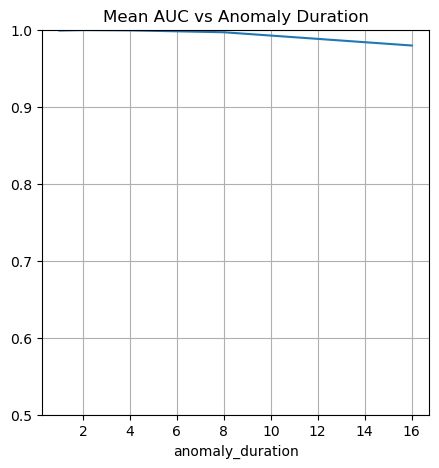

In [7]:
display(dfm2)
fig = plt.figure(figsize=(5,5))
dfm2.plot()
plt.grid()
plt.title("Mean AUC vs Anomaly Duration");
plt.ylim([0.5,1]);

In [14]:
client.shutdown()

2023-08-29 09:37:14,482 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
